In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, FastICA

import random
from pathlib import Path

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-iw__rq69 because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
ROOT_DIR = "/data" if Path("/data").exists() else "."
ROOT_DIR = f"{ROOT_DIR}/figures"
Path(ROOT_DIR).mkdir(exist_ok=True)

## Functions

In [3]:
ext = "jpg"

# Use if latex support is installed

# import matplotlib as mpl
#ext = pgf
# mpl.use('pgf')
# from math import sqrt
# default_width = 5.78853 
# default_ratio = (sqrt(5.0) - 1.0) / 2.0 
# mpl.rcParams["text.usetex"] = True
# mpl.rcParams["pgf.texsystem"] = "pdflatex"
# mpl.rcParams["pgf.rcfonts"] = False
# mpl.rcParams["font.family"] = "serif"
# mpl.rcParams["font.sans-serif"] = []
# mpl.rcParams["font.monospace"] = []
# mpl.rcParams["figure.figsize"] = [default_width, default_width * default_ratio]
# %matplotlib inline
# plt.close("all")

In [4]:
def set_seeds(seed):
    os.environ["PYTHONHASHSEED"] = str(seed)
    os.environ["TF_DETERMINISTIC_OPS"] = "1"
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)



class Orthogonal(tf.keras.regularizers.Regularizer):
    def __init__(self, gain=1.0, diag=True, axis=0):
        self.gain = gain
        self.diag = diag
        self.axis = axis

    def __call__(self, w):
        wf = tf.reshape(w, (-1, w.shape[-1]))
        if self.axis == 1:
            wf = tf.transpose((wf))
        if self.diag:
            dw = self.gain * tf.reduce_sum(
                tf.square(
                    tf.matmul(wf, wf, transpose_a=True)
                    - tf.eye(wf.shape[-1], wf.shape[-1])
                )
            )
        else:
            wf2 = tf.matmul(wf, wf, transpose_a=True)
            dw = self.gain * tf.reduce_sum(
                tf.square(wf2 - tf.linalg.band_part(wf2, 0, 0))
            )
        return dw

    def get_config(self):
        return {"gain": self.gain}



# Signals

### Orthogonal mixing


In [5]:
def create_rotation_matrix(theta, phi):
    rx = np.array(
        [
            [1, 0, 0],
            [0, np.cos(theta), -np.sin(theta)],
            [0, np.sin(theta), np.cos(theta)],
        ]
    )
    ry = np.array(
        [[np.cos(phi), 0, np.sin(phi)], [0, 1, 0], [-np.sin(phi), 0, np.cos(phi)]]
    )
    r = np.dot(rx, ry)
    return r

In [6]:
import numpy as np
from scipy import signal


def generate_signals():
    np.random.seed(0)
    n_samples = 2000
    time = np.linspace(0, 8, n_samples)

    s1 = 6 * np.sin(2 * time)  # Signal 1 : sinusoidal signal
    s2 = 3 * np.sign(np.sin(3 * time))  # Signal 2 : square signal
    s3 = signal.sawtooth(2 * np.pi * time)  # Signal 3: saw tooth signal

    S = np.c_[s1, s2, s3]
    S += 0.2 * np.random.normal(size=S.shape)  # Add noise

    return S


def compute_ica_pca(X):
    # Compute ICA
    ica = FastICA(n_components=3, whiten="unit-variance", max_iter=400, tol=1e-5)
    S_ = ica.fit_transform(X)  # Reconstruct signals
    A_ = ica.mixing_  # Get estimated mixing matrix

    # We can `prove` that the ICA model applies by reverting the unmixing.
    assert np.allclose(X, np.dot(S_, A_.T) + ica.mean_)

    # assume unit norm
    W = ica.components_.T
    W /= np.sqrt(np.sum(W * W, axis=0))
    S_ = np.dot(X, W)

    # For comparison, compute PCA
    pca = PCA(n_components=3)
    H = pca.fit_transform(X)

    return S_, H

In [7]:
class RecDense(layers.Dense):
    def __init__(self, *args, stop_gradient=True, **kwargs):
        super().__init__(*args, **kwargs)
        self.stop_gradient = stop_gradient

    def build(self, input_shape):
        super().build(input_shape)
        self.moving_variance = self.add_weight(
            "var", shape=self.units, initializer="ones", trainable=False
        )

    def call(self, inputs, training=None):
        if training is None:
            training = keras.backend.learning_phase()
        kernel = self.kernel / tf.sqrt(
            tf.reduce_sum(tf.square(self.kernel), axis=0, keepdims=True)
        )
        kernel = self.kernel

        y = tf.matmul(inputs, kernel)
        if training:
            mean = tf.math.reduce_mean(y, axis=0)

            var = tf.math.reduce_variance(y, axis=0)
            self.moving_variance.assign_add(0.01 * (var - self.moving_variance))

            # std = tf.sqrt(1e-3 + var)
            std = tf.sqrt(1e-3 + self.moving_variance)
            ym = y - mean
            ys = ym / std

            self.add_metric(tf.reduce_max(y), "max")
            self.add_metric(tf.reduce_min(y), "min")
            self.add_metric(tf.math.reduce_variance(y), "var")

            yr = std * self.activation(ys)

            dkernel = tf.stop_gradient((kernel)) if self.stop_gradient else kernel
            loss = tf.reduce_mean(
                tf.reduce_sum(
                    tf.square(
                        tf.matmul(yr, dkernel, transpose_b=True)
                        - inputs
                        + tf.reduce_mean(inputs, axis=0)
                    ),
                    axis=1,
                )
            )

            self.add_loss(loss)

        if self.use_bias:
            y += self.bias
        return y

#### All signals distinct variance


In [8]:
theta = -np.pi / 4
phi = np.pi / 3
dim = 3

A = create_rotation_matrix(theta, phi)  # mixing matrix

S = generate_signals()

# Mix data
X = np.dot(S, A.T)  # Generate observations

S_, H = compute_ica_pca(X)

In [9]:
s = 0.8
dense = RecDense(
    dim,
    stop_gradient=True,
    kernel_constraint=keras.constraints.UnitNorm([0]),
    kernel_initializer=keras.initializers.Orthogonal(),
    activation=lambda a: s * tf.nn.tanh(a / s),
    use_bias=False,
)

model = keras.Sequential(dense)


model.compile(
    keras.optimizers.SGD(0.01, 0.9)
)
model.fit(
    X,
    epochs=200,
    batch_size=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor="loss",
            mode="auto",
            patience=1000,
            restore_best_weights=True,
            start_from_epoch=0,
        ),
    ],
)

Epoch 1/200
20/20 [==============================] - 1s 1ms/step - loss: 12.9508 - max: 6.2306 - min: -6.2300 - var: 9.0704
Epoch 2/200
20/20 [==============================] - 0s 984us/step - loss: 9.2956 - max: 6.2895 - min: -6.2670 - var: 9.3661
Epoch 3/200
20/20 [==============================] - 0s 989us/step - loss: 7.7695 - max: 6.2715 - min: -6.2605 - var: 9.0806
Epoch 4/200
20/20 [==============================] - 0s 1ms/step - loss: 6.7877 - max: 6.1960 - min: -6.2090 - var: 8.9463
Epoch 5/200
20/20 [==============================] - 0s 977us/step - loss: 6.0616 - max: 6.2120 - min: -6.2105 - var: 8.9380
Epoch 6/200
20/20 [==============================] - 0s 1ms/step - loss: 5.5803 - max: 6.1795 - min: -6.1688 - var: 8.9436
Epoch 7/200
20/20 [==============================] - 0s 990us/step - loss: 5.2361 - max: 6.1962 - min: -6.1802 - var: 8.9273
Epoch 8/200
20/20 [==============================] - 0s 1ms/step - loss: 4.9346 - max: 6.1881 - min: -6.2007 - var: 8.9416
Epoch 9

20/20 [==============================] - 0s 942us/step - loss: 4.0286 - max: 6.1663 - min: -6.2184 - var: 8.9386
Epoch 67/200
20/20 [==============================] - 0s 927us/step - loss: 4.0383 - max: 6.2059 - min: -6.2496 - var: 8.9422
Epoch 68/200
20/20 [==============================] - 0s 952us/step - loss: 4.0040 - max: 6.1955 - min: -6.2190 - var: 8.9405
Epoch 69/200
20/20 [==============================] - 0s 922us/step - loss: 4.0054 - max: 6.1886 - min: -6.1982 - var: 8.9261
Epoch 70/200
20/20 [==============================] - 0s 920us/step - loss: 4.0193 - max: 6.1813 - min: -6.1998 - var: 8.9281
Epoch 71/200
20/20 [==============================] - 0s 923us/step - loss: 4.0420 - max: 6.1820 - min: -6.2069 - var: 8.9418
Epoch 72/200
20/20 [==============================] - 0s 918us/step - loss: 4.0092 - max: 6.2037 - min: -6.1867 - var: 8.9182
Epoch 73/200
20/20 [==============================] - 0s 929us/step - loss: 4.0325 - max: 6.1968 - min: -6.2139 - var: 8.9211
Epoch

20/20 [==============================] - 0s 965us/step - loss: 4.0452 - max: 6.2009 - min: -6.2303 - var: 8.9268
Epoch 131/200
20/20 [==============================] - 0s 951us/step - loss: 4.0269 - max: 6.2059 - min: -6.2204 - var: 8.9476
Epoch 132/200
20/20 [==============================] - 0s 945us/step - loss: 4.0344 - max: 6.1821 - min: -6.2278 - var: 8.9543
Epoch 133/200
20/20 [==============================] - 0s 1ms/step - loss: 4.0325 - max: 6.1995 - min: -6.2154 - var: 8.9253
Epoch 134/200
20/20 [==============================] - 0s 923us/step - loss: 4.0384 - max: 6.2138 - min: -6.1969 - var: 8.9280
Epoch 135/200
20/20 [==============================] - 0s 931us/step - loss: 4.0462 - max: 6.1939 - min: -6.2368 - var: 8.9349
Epoch 136/200
20/20 [==============================] - 0s 966us/step - loss: 4.0222 - max: 6.1922 - min: -6.2291 - var: 8.9455
Epoch 137/200
20/20 [==============================] - 0s 943us/step - loss: 4.0163 - max: 6.1818 - min: -6.2206 - var: 8.9245


20/20 [==============================] - 0s 991us/step - loss: 4.0283 - max: 6.2117 - min: -6.2403 - var: 8.9496
Epoch 195/200
20/20 [==============================] - 0s 1ms/step - loss: 4.0210 - max: 6.1830 - min: -6.2122 - var: 8.9544
Epoch 196/200
20/20 [==============================] - 0s 979us/step - loss: 4.0399 - max: 6.1912 - min: -6.2177 - var: 8.9409
Epoch 197/200
20/20 [==============================] - 0s 958us/step - loss: 4.0428 - max: 6.2123 - min: -6.2120 - var: 8.9366
Epoch 198/200
20/20 [==============================] - 0s 938us/step - loss: 4.0164 - max: 6.1725 - min: -6.1863 - var: 8.9368
Epoch 199/200
20/20 [==============================] - 0s 944us/step - loss: 4.0213 - max: 6.1828 - min: -6.2344 - var: 8.9502
Epoch 200/200
20/20 [==============================] - 0s 947us/step - loss: 4.0267 - max: 6.2056 - min: -6.2183 - var: 8.9281


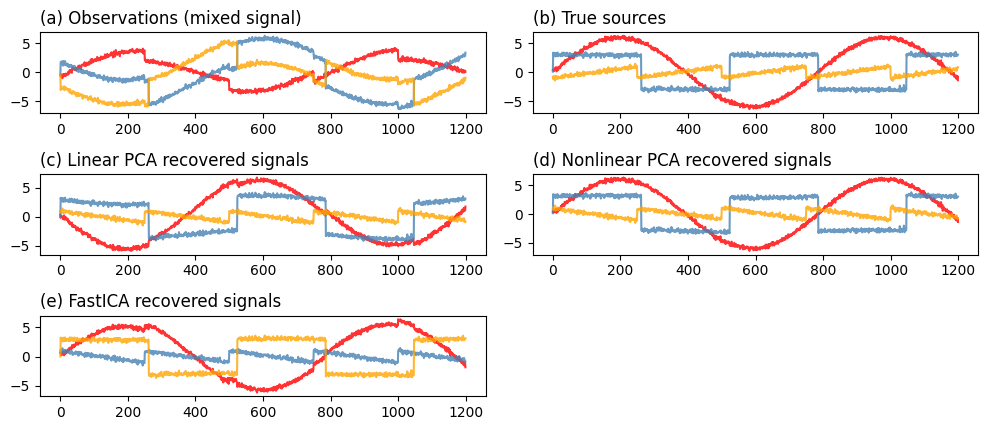

In [10]:
plt.figure(figsize=(10, 7))
Sr_ = model(X)
Sr_ = Sr_.numpy()
models = [X, S, H, Sr_, S_]
names = [
    "(a) Observations (mixed signal)",
    "(b) True sources",
    "(c) Linear PCA recovered signals",
    "(d) Nonlinear PCA recovered signals",
    "(e) FastICA recovered signals",
]
colors = ["red", "steelblue", "orange"]

for ii, (model1, name) in enumerate(zip(models, names), 1):
    ax = plt.subplot(len(models), 2, ii)

    plt.title(name, loc="left")
    for sig, color in zip(model1.T, colors):
        plt.plot(sig[:1200], color=color, alpha=0.8)


plt.tight_layout()
# plt.show()
plt.savefig(f"{ROOT_DIR}/signals-orthogonal-distinct-variance.{ext}", bbox_inches="tight")

#### Three signals with two having the same variance

In [11]:
theta = -np.pi / 4
phi = np.pi / 3
A = create_rotation_matrix(theta, phi)  # mixing matrix

S = generate_signals()

std = S.std(axis=0)
std[0] = 1.0
S /= std  # Standardize the last 2 and 3

# Mix data
X = np.dot(S, A.T)  # Generate observations
S.std(axis=0)
S_, H = compute_ica_pca(X)
dim = 3

In [12]:
s = 0.8
dense = RecDense(
    dim,
    stop_gradient=True,
    kernel_constraint=keras.constraints.UnitNorm([0]),
    kernel_initializer=keras.initializers.Orthogonal(),
    activation=lambda a: s * tf.nn.tanh(a / s),
    use_bias=False,
)

model = keras.Sequential([dense])


model.compile(

    keras.optimizers.SGD(0.01, 0.9)
)
model.fit(
    X,
    epochs=200,
    batch_size=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor="loss",
            mode="auto",
            patience=1000,
            restore_best_weights=True,
            start_from_epoch=0,
        ),
    ],
)

Epoch 1/200
20/20 [==============================] - 0s 995us/step - loss: 8.3124 - max: 5.5254 - min: -5.2644 - var: 7.4374
Epoch 2/200
20/20 [==============================] - 0s 959us/step - loss: 5.3554 - max: 5.7153 - min: -5.5262 - var: 8.8026
Epoch 3/200
20/20 [==============================] - 0s 974us/step - loss: 4.3761 - max: 5.7353 - min: -5.6212 - var: 8.4589
Epoch 4/200
20/20 [==============================] - 0s 991us/step - loss: 3.6628 - max: 5.9491 - min: -5.7402 - var: 8.5207
Epoch 5/200
20/20 [==============================] - 0s 957us/step - loss: 3.2409 - max: 6.0289 - min: -5.8940 - var: 8.4712
Epoch 6/200
20/20 [==============================] - 0s 973us/step - loss: 3.1357 - max: 6.0214 - min: -6.0683 - var: 8.1951
Epoch 7/200
20/20 [==============================] - 0s 944us/step - loss: 3.8671 - max: 6.2091 - min: -6.1756 - var: 7.2117
Epoch 8/200
20/20 [==============================] - 0s 936us/step - loss: 4.3390 - max: 6.1674 - min: -6.2321 - var: 6.5873


20/20 [==============================] - 0s 955us/step - loss: 3.2990 - max: 6.1939 - min: -6.1935 - var: 6.4886
Epoch 67/200
20/20 [==============================] - 0s 945us/step - loss: 3.2870 - max: 6.2021 - min: -6.1927 - var: 6.4841
Epoch 68/200
20/20 [==============================] - 0s 926us/step - loss: 3.2806 - max: 6.1984 - min: -6.2155 - var: 6.4815
Epoch 69/200
20/20 [==============================] - 0s 927us/step - loss: 3.2909 - max: 6.2131 - min: -6.2293 - var: 6.4920
Epoch 70/200
20/20 [==============================] - 0s 952us/step - loss: 3.3028 - max: 6.2112 - min: -6.2004 - var: 6.5005
Epoch 71/200
20/20 [==============================] - 0s 949us/step - loss: 3.2797 - max: 6.2048 - min: -6.2510 - var: 6.4861
Epoch 72/200
20/20 [==============================] - 0s 942us/step - loss: 3.3162 - max: 6.1963 - min: -6.2214 - var: 6.4948
Epoch 73/200
20/20 [==============================] - 0s 935us/step - loss: 3.2920 - max: 6.1947 - min: -6.2215 - var: 6.4880
Epoch

20/20 [==============================] - 0s 927us/step - loss: 3.3047 - max: 6.1806 - min: -6.2233 - var: 6.4942
Epoch 131/200
20/20 [==============================] - 0s 942us/step - loss: 3.2891 - max: 6.1934 - min: -6.2028 - var: 6.4795
Epoch 132/200
20/20 [==============================] - 0s 935us/step - loss: 3.2873 - max: 6.2052 - min: -6.2132 - var: 6.4917
Epoch 133/200
20/20 [==============================] - 0s 1ms/step - loss: 3.3127 - max: 6.2114 - min: -6.1660 - var: 6.4935
Epoch 134/200
20/20 [==============================] - 0s 1ms/step - loss: 3.2836 - max: 6.1832 - min: -6.2195 - var: 6.4847
Epoch 135/200
20/20 [==============================] - 0s 1ms/step - loss: 3.3056 - max: 6.2018 - min: -6.2194 - var: 6.4908
Epoch 136/200
20/20 [==============================] - 0s 1ms/step - loss: 3.3069 - max: 6.2209 - min: -6.1875 - var: 6.4820
Epoch 137/200
20/20 [==============================] - 0s 989us/step - loss: 3.2827 - max: 6.2068 - min: -6.2278 - var: 6.4904
Epoch 

20/20 [==============================] - 0s 940us/step - loss: 3.3170 - max: 6.1845 - min: -6.2182 - var: 6.4879
Epoch 195/200
20/20 [==============================] - 0s 937us/step - loss: 3.2292 - max: 6.1869 - min: -6.1783 - var: 6.4580
Epoch 196/200
20/20 [==============================] - 0s 941us/step - loss: 3.3115 - max: 6.2059 - min: -6.2022 - var: 6.4849
Epoch 197/200
20/20 [==============================] - 0s 939us/step - loss: 3.3085 - max: 6.1978 - min: -6.2181 - var: 6.4940
Epoch 198/200
20/20 [==============================] - 0s 940us/step - loss: 3.3095 - max: 6.1912 - min: -6.1793 - var: 6.4787
Epoch 199/200
20/20 [==============================] - 0s 931us/step - loss: 3.3041 - max: 6.2146 - min: -6.1917 - var: 6.4835
Epoch 200/200
20/20 [==============================] - 0s 943us/step - loss: 3.2848 - max: 6.2059 - min: -6.1926 - var: 6.4743


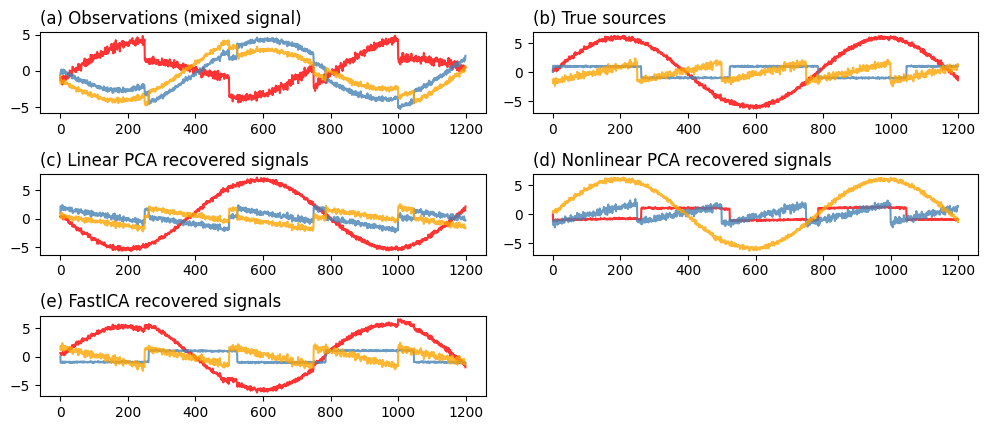

In [13]:
plt.figure(figsize=(10, 7))
Sr_ = model(X)
Sr_ = Sr_.numpy()
models = [X, S, H, Sr_, S_]
names = [
    "(a) Observations (mixed signal)",
    "(b) True sources",
    "(c) Linear PCA recovered signals",
    "(d) Nonlinear PCA recovered signals",
    "(e) FastICA recovered signals",
]
colors = ["red", "steelblue", "orange"]

for ii, (model1, name) in enumerate(zip(models, names), 1):
    ax = plt.subplot(len(models), 2, ii)

    plt.title(name, loc="left")
    for sig, color in zip(model1.T, colors):
        plt.plot(sig[:1200], color=color, alpha=0.8)


plt.tight_layout()
# plt.show()
plt.savefig(f"{ROOT_DIR}/signals-orthogonal.{ext}", bbox_inches="tight")

#### All signals same variance

In [14]:
theta = -np.pi / 4
phi = np.pi / 3
dim = 3

A = create_rotation_matrix(theta, phi)  # mixing matrix

S = generate_signals()

S /= S.std(axis=0)
X = np.dot(S, A.T)
X /= X.std(axis=0)

In [15]:
S_, H = compute_ica_pca(X)

In [16]:
dim = 3
s = 0.8
dense = RecDense(
    dim,
    stop_gradient=True,
    kernel_constraint=keras.constraints.UnitNorm([0]),
    kernel_initializer=keras.initializers.Orthogonal(),
    activation=lambda a: s * tf.nn.tanh(a / s),
    use_bias=False,
)

model = keras.Sequential([dense])

In [17]:
model.compile(
    # keras.optimizers.Adam(0.01 )
    keras.optimizers.SGD(0.01, 0.9)
)
model.fit(
    X,
    epochs=200,
    batch_size=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor="loss",
            mode="auto",
            patience=1000,
            restore_best_weights=True,
            start_from_epoch=0,
        ),
    ],
)

Epoch 1/200
20/20 [==============================] - 1s 1ms/step - loss: 0.6206 - max: 2.3017 - min: -2.4418 - var: 0.9979
Epoch 2/200
20/20 [==============================] - 0s 969us/step - loss: 0.6153 - max: 2.2746 - min: -2.4345 - var: 0.9941
Epoch 3/200
20/20 [==============================] - 0s 963us/step - loss: 0.6059 - max: 2.2740 - min: -2.4415 - var: 0.9935
Epoch 4/200
20/20 [==============================] - 0s 987us/step - loss: 0.6068 - max: 2.2686 - min: -2.4183 - var: 0.9976
Epoch 5/200
20/20 [==============================] - 0s 1ms/step - loss: 0.5994 - max: 2.2681 - min: -2.4180 - var: 0.9962
Epoch 6/200
20/20 [==============================] - 0s 979us/step - loss: 0.5928 - max: 2.2647 - min: -2.4082 - var: 0.9992
Epoch 7/200
20/20 [==============================] - 0s 982us/step - loss: 0.5840 - max: 2.2501 - min: -2.4405 - var: 0.9970
Epoch 8/200
20/20 [==============================] - 0s 1ms/step - loss: 0.5769 - max: 2.2127 - min: -2.3758 - var: 0.9979
Epoch 

20/20 [==============================] - 0s 930us/step - loss: 0.4865 - max: 2.0639 - min: -2.0094 - var: 1.0025
Epoch 67/200
20/20 [==============================] - 0s 947us/step - loss: 0.4877 - max: 2.0038 - min: -2.0345 - var: 1.0018
Epoch 68/200
20/20 [==============================] - 0s 927us/step - loss: 0.4856 - max: 1.9929 - min: -2.0373 - var: 1.0020
Epoch 69/200
20/20 [==============================] - 0s 924us/step - loss: 0.4866 - max: 2.0632 - min: -2.0239 - var: 1.0027
Epoch 70/200
20/20 [==============================] - 0s 927us/step - loss: 0.4862 - max: 2.0539 - min: -2.0477 - var: 1.0028
Epoch 71/200
20/20 [==============================] - 0s 939us/step - loss: 0.4849 - max: 2.0169 - min: -2.0451 - var: 1.0021
Epoch 72/200
20/20 [==============================] - 0s 945us/step - loss: 0.4880 - max: 1.9843 - min: -2.0277 - var: 1.0023
Epoch 73/200
20/20 [==============================] - 0s 1ms/step - loss: 0.4898 - max: 2.0457 - min: -2.0133 - var: 1.0004
Epoch 7

20/20 [==============================] - 0s 943us/step - loss: 0.4853 - max: 1.9928 - min: -2.0647 - var: 1.0039
Epoch 131/200
20/20 [==============================] - 0s 937us/step - loss: 0.4851 - max: 2.0253 - min: -2.0642 - var: 1.0026
Epoch 132/200
20/20 [==============================] - 0s 951us/step - loss: 0.4847 - max: 2.0192 - min: -2.0004 - var: 1.0009
Epoch 133/200
20/20 [==============================] - 0s 944us/step - loss: 0.4857 - max: 2.0505 - min: -2.0214 - var: 1.0036
Epoch 134/200
20/20 [==============================] - 0s 929us/step - loss: 0.4857 - max: 2.0154 - min: -1.9883 - var: 1.0018
Epoch 135/200
20/20 [==============================] - 0s 955us/step - loss: 0.4868 - max: 2.0156 - min: -2.0164 - var: 1.0028
Epoch 136/200
20/20 [==============================] - 0s 934us/step - loss: 0.4868 - max: 2.0477 - min: -1.9908 - var: 1.0025
Epoch 137/200
20/20 [==============================] - 0s 925us/step - loss: 0.4892 - max: 2.0026 - min: -2.0082 - var: 1.002

20/20 [==============================] - 0s 931us/step - loss: 0.4893 - max: 2.0266 - min: -2.0347 - var: 1.0022
Epoch 195/200
20/20 [==============================] - 0s 925us/step - loss: 0.4865 - max: 2.0457 - min: -2.0329 - var: 1.0029
Epoch 196/200
20/20 [==============================] - 0s 953us/step - loss: 0.4866 - max: 2.0100 - min: -2.0034 - var: 1.0020
Epoch 197/200
20/20 [==============================] - 0s 923us/step - loss: 0.4852 - max: 1.9997 - min: -1.9913 - var: 1.0034
Epoch 198/200
20/20 [==============================] - 0s 942us/step - loss: 0.4892 - max: 2.0219 - min: -1.9796 - var: 1.0031
Epoch 199/200
20/20 [==============================] - 0s 2ms/step - loss: 0.4834 - max: 2.0356 - min: -1.9788 - var: 1.0022
Epoch 200/200
20/20 [==============================] - 0s 1ms/step - loss: 0.4884 - max: 2.0629 - min: -2.0312 - var: 1.0028


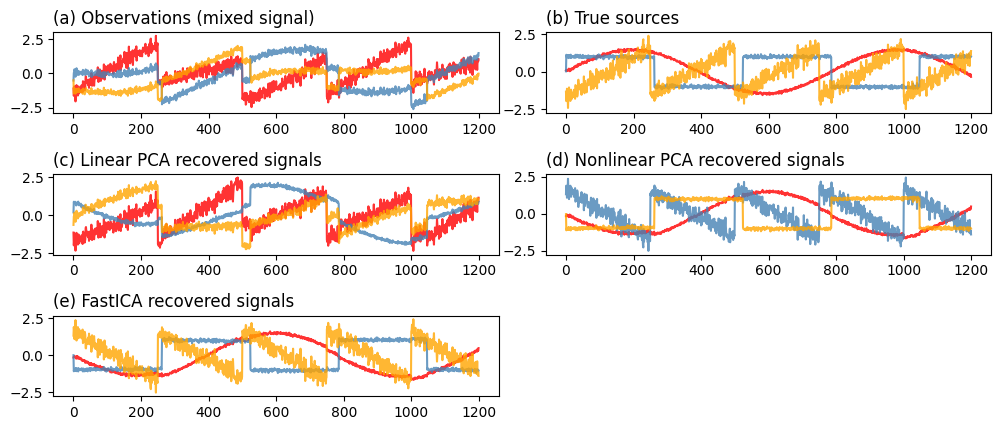

In [18]:
plt.figure(figsize=(10, 7))
Sr_ = model(X)
Sr_ = Sr_.numpy()
models = [X, S, H, Sr_, S_]
names = [
    "(a) Observations (mixed signal)",
    "(b) True sources",
    "(c) Linear PCA recovered signals",
    "(d) Nonlinear PCA recovered signals",
    "(e) FastICA recovered signals",
]
colors = ["red", "steelblue", "orange"]

for ii, (model1, name) in enumerate(zip(models, names), 1):
    ax = plt.subplot(len(models), 2, ii)

    plt.title(name, loc="left")
    for sig, color in zip(model1.T, colors):
        plt.plot(sig[:1200], color=color, alpha=0.8)


plt.tight_layout()
# plt.show()
plt.savefig(f"{ROOT_DIR}/signals-orthogonal-same-variance.{ext}", bbox_inches="tight")

## non-orthogonal

In [19]:
class RecDense2(layers.Dense):
    def __init__(
        self, *args, stop_gradient=True, use_sigma=True, normalise=False, **kwargs
    ):
        super().__init__(*args, **kwargs)
        self.stop_gradient = stop_gradient
        self.use_sigma = use_sigma
        self.normalise = normalise

    def build(self, input_shape):
        super().build(input_shape)
        self.moving_mean = self.add_weight(
            "mean", shape=self.units, initializer="zeros", trainable=False
        )
        self.moving_variance = self.add_weight(
            "var", shape=self.units, initializer="ones", trainable=False
        )
        self.alpha = 0.01

    def call(self, inputs, training=None):
        if training is None:
            training = keras.backend.learning_phase()

        if self.normalise:
            kernel = self.kernel / tf.sqrt(
                tf.reduce_sum(tf.square(self.kernel), axis=0, keepdims=True)
            )
        else:
            kernel = self.kernel
        y = tf.matmul(inputs, kernel)

        if training:
            mean = tf.math.reduce_mean(y, axis=0)

            self.moving_mean.assign_add(self.alpha * (mean - self.moving_mean))
            if self.use_sigma:
                var = tf.math.reduce_variance(y, axis=0)
                self.moving_variance.assign_add(
                    self.alpha * (var - self.moving_variance)
                )
                std = tf.sqrt(1e-3 + self.moving_variance)
            else:
                std = 1.0

            ym = y - mean
            ys = ym / std

            self.add_metric(tf.reduce_max(y), "max")
            self.add_metric(tf.reduce_min(y), "min")
            self.add_metric(tf.math.reduce_variance(y), "var")

            yr = std * self.activation(ys)

            dkernel = tf.stop_gradient((kernel)) if self.stop_gradient else kernel
            loss = tf.reduce_mean(
                tf.reduce_sum(
                    tf.square(
                        tf.matmul(yr, dkernel, transpose_b=True)
                        - inputs
                        + tf.reduce_mean(inputs, axis=0)
                    ),
                    axis=1,
                )
            )

            self.add_loss(loss)
            return ys

        if self.use_bias:
            y += self.bias
        return (y - self.moving_mean) / tf.sqrt(1e-3 + self.moving_variance)

In [20]:
A = np.array([[1, 1, 1], [0.5, 2, 1.0], [1.5, 1.0, 2.0]])  # Mixing matrix
A = np.random.rand(3, 3)
A /= np.sqrt(np.sum(A * A, axis=0))

S = generate_signals()

# Mix data
X = np.dot(S, A)

In [21]:
Ai = np.linalg.inv(A)

In [22]:
np.sqrt(np.sum(Ai * Ai, axis=0))

array([1.54215349, 2.19887288, 1.86943577])

In [23]:
X.std(axis=0)

array([3.43654447, 3.75830494, 2.06794387])

In [24]:
dim = 3
s = 0.8
dense = RecDense2(
    dim,
    stop_gradient=True,
    normalise=False,
    kernel_constraint=keras.constraints.UnitNorm([0]),
    activation=lambda a: s * tf.nn.tanh(a / s),
    use_bias=False,
)
dense2 = RecDense2(
    dim,
    stop_gradient=True,
    use_sigma=False,
    normalise=False,
    kernel_constraint=keras.constraints.UnitNorm([0]),
    activation=lambda a: s * tf.nn.tanh(a / s),
    use_bias=False,
)
inp = keras.Input((dim,))
x = inp
x = dense2(tf.stop_gradient(dense(x)))
model = keras.Model(inp, x)

if using Adam, it seems better to also use differentiable unit norm weight normalisation

In [25]:
model.compile(
    keras.optimizers.SGD(0.01, 0.9)
    # keras.optimizers.Adam(0.01)
)
model.fit(X, epochs=200, batch_size=100)

Epoch 1/200
20/20 [==============================] - 1s 1ms/step - loss: 24.5098 - max: 3.5168 - min: -3.9850 - var: 2.9321
Epoch 2/200
20/20 [==============================] - 0s 1ms/step - loss: 13.4596 - max: 3.7920 - min: -3.5208 - var: 2.8612
Epoch 3/200
20/20 [==============================] - 0s 1ms/step - loss: 10.7030 - max: 3.4411 - min: -3.1539 - var: 1.9692
Epoch 4/200
20/20 [==============================] - 0s 1ms/step - loss: 9.0922 - max: 3.1033 - min: -2.8662 - var: 1.6185
Epoch 5/200
20/20 [==============================] - 0s 1ms/step - loss: 8.0857 - max: 2.8675 - min: -2.6409 - var: 1.4223
Epoch 6/200
20/20 [==============================] - 0s 1ms/step - loss: 7.4282 - max: 2.6714 - min: -2.4904 - var: 1.2801
Epoch 7/200
20/20 [==============================] - 0s 1ms/step - loss: 6.9557 - max: 2.4669 - min: -2.3388 - var: 1.1337
Epoch 8/200
20/20 [==============================] - 0s 1ms/step - loss: 6.6184 - max: 2.3424 - min: -2.2052 - var: 1.0620
Epoch 9/200
2

20/20 [==============================] - 0s 1ms/step - loss: 6.8223 - max: 2.0353 - min: -2.0063 - var: 0.9963
Epoch 68/200
20/20 [==============================] - 0s 1ms/step - loss: 6.8000 - max: 2.0852 - min: -2.0700 - var: 0.9988
Epoch 69/200
20/20 [==============================] - 0s 1ms/step - loss: 6.7328 - max: 2.0446 - min: -2.0349 - var: 0.9954
Epoch 70/200
20/20 [==============================] - 0s 1ms/step - loss: 6.7770 - max: 2.0299 - min: -2.0543 - var: 0.9966
Epoch 71/200
20/20 [==============================] - 0s 1ms/step - loss: 6.7906 - max: 2.0418 - min: -2.0790 - var: 0.9963
Epoch 72/200
20/20 [==============================] - 0s 1ms/step - loss: 6.7825 - max: 1.9860 - min: -2.0003 - var: 0.9977
Epoch 73/200
20/20 [==============================] - 0s 1ms/step - loss: 6.7982 - max: 2.0677 - min: -2.0289 - var: 0.9994
Epoch 74/200
20/20 [==============================] - 0s 1ms/step - loss: 6.7923 - max: 2.0250 - min: -1.9978 - var: 0.9965
Epoch 75/200
20/20 [=

20/20 [==============================] - 0s 1ms/step - loss: 6.7490 - max: 2.0391 - min: -2.0757 - var: 0.9949
Epoch 133/200
20/20 [==============================] - 0s 1ms/step - loss: 6.7908 - max: 2.0354 - min: -1.9923 - var: 0.9923
Epoch 134/200
20/20 [==============================] - 0s 1ms/step - loss: 6.7888 - max: 2.0444 - min: -2.0567 - var: 0.9977
Epoch 135/200
20/20 [==============================] - 0s 1ms/step - loss: 6.7420 - max: 2.0313 - min: -2.0707 - var: 0.9920
Epoch 136/200
20/20 [==============================] - 0s 1ms/step - loss: 6.8287 - max: 2.0482 - min: -1.9919 - var: 1.0002
Epoch 137/200
20/20 [==============================] - 0s 1ms/step - loss: 6.8230 - max: 2.0674 - min: -2.0094 - var: 0.9985
Epoch 138/200
20/20 [==============================] - 0s 1ms/step - loss: 6.8066 - max: 2.0300 - min: -2.0561 - var: 0.9996
Epoch 139/200
20/20 [==============================] - 0s 1ms/step - loss: 6.7921 - max: 2.0234 - min: -2.0246 - var: 0.9972
Epoch 140/200


20/20 [==============================] - 0s 1ms/step - loss: 6.7757 - max: 2.0441 - min: -2.0375 - var: 0.9993
Epoch 198/200
20/20 [==============================] - 0s 1ms/step - loss: 6.7751 - max: 2.0131 - min: -2.0692 - var: 0.9970
Epoch 199/200
20/20 [==============================] - 0s 1ms/step - loss: 6.8117 - max: 2.0258 - min: -2.0415 - var: 0.9964
Epoch 200/200
20/20 [==============================] - 0s 1ms/step - loss: 6.7642 - max: 2.0584 - min: -2.0152 - var: 0.9970


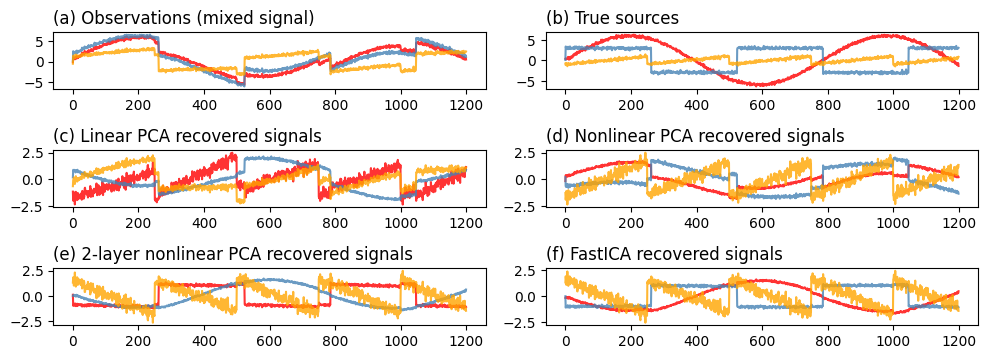

In [26]:
plt.figure(figsize=(10, 7))
Sr_ = model(X)
Sr_ = Sr_.numpy()

Sr1_ = model.layers[1](X)
Sr1_ = Sr1_.numpy()
models = [X, S, H / H.std(0), Sr1_, Sr_, S_ / S_.std(0)]
models = [X, S, H, Sr1_, Sr_, S_]
names = [
    "(a) Observations (mixed signal)",
    "(b) True sources",
    "(c) Linear PCA recovered signals",
    "(d) Nonlinear PCA recovered signals",
    "(e) 2-layer nonlinear PCA recovered signals",
    "(f) FastICA recovered signals",
]
colors = ["red", "steelblue", "orange"]

for ii, (model1, name) in enumerate(zip(models, names), 1):
    ax = plt.subplot(len(models), 2, ii)

    plt.title(name, loc="left")
    for sig, color in zip(model1.T, colors):
        plt.plot(sig[:1200], color=color, alpha=0.8)


plt.tight_layout()
# plt.show()
plt.savefig(f"{ROOT_DIR}/signals-non-orthogonal.{ext}", bbox_inches="tight")